Iter: 0, Loss: 3.335e+03, Time: 0.85
Mass Residual: 0.000061		Momentum Residual: 0.000215	Energy Residual: 0.000003
Iter: 1000, Loss: 2.279e+01, Time: 4.42
Mass Residual: 0.000099		Momentum Residual: 0.032623	Energy Residual: 0.003021
Iter: 2000, Loss: 1.200e+01, Time: 4.44
Mass Residual: 0.000193		Momentum Residual: 0.031952	Energy Residual: 0.004605
Iter: 3000, Loss: 8.744e+00, Time: 4.49
Mass Residual: 0.000249		Momentum Residual: 0.032097	Energy Residual: 0.005353
Iter: 4000, Loss: 6.785e+00, Time: 4.43
Mass Residual: 0.000520		Momentum Residual: 0.032144	Energy Residual: 0.010469
Iter: 5000, Loss: 5.118e+00, Time: 4.45
Mass Residual: 0.000890		Momentum Residual: 0.032189	Energy Residual: 0.018605
Iter: 6000, Loss: 4.316e+00, Time: 4.44
Mass Residual: 0.001032		Momentum Residual: 0.032229	Energy Residual: 0.021332
Iter: 7000, Loss: 3.912e+00, Time: 4.45
Mass Residual: 0.001170		Momentum Residual: 0.032198	Energy Residual: 0.024959
Iter: 8000, Loss: 3.572e+00, Time: 4.42
Mass Residu

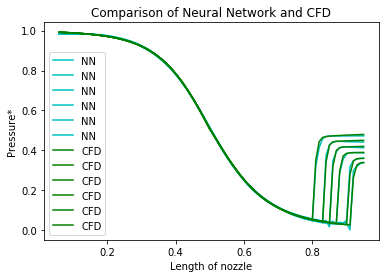

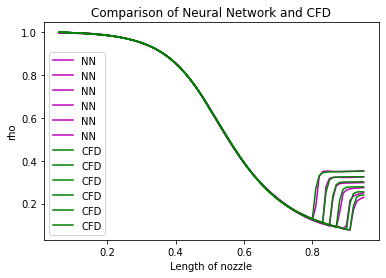

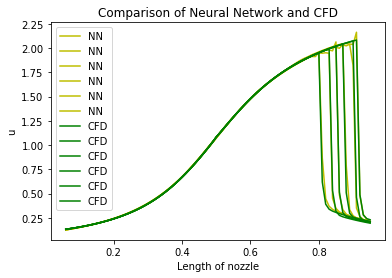

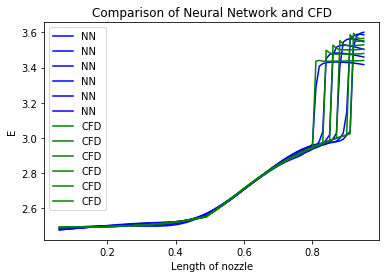

In [5]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

np.random.seed(1234)
tf.set_random_seed(1234)

class NN:
    # Initialize the class
    def __init__(self, P_back, x, P, rho, u, E, layers):
        
        X = np.concatenate([P_back, x], 1)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
        self.X = X
        self.P_back = P_back
        self.x = x
        self.P = P
        self.rho = rho
        self.u = u
        self.E = E

        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.P_back_tf = tf.placeholder(tf.float32, shape=[None, self.P_back.shape[1]])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.P_tf = tf.placeholder(tf.float32, shape=[None, self.P.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.E_tf = tf.placeholder(tf.float32, shape=[None, self.E.shape[1]])
        
        self.P_pred, self.rho_pred, self.u_pred, self.E_pred, self.e1, self.e2, self.e3= self.net_NS(self.P_back_tf, self.x_tf)

        # MSE Normalization
        P_norm = np.amax(P)
        rho_norm = np.amax(rho)
        u_norm = np.amax(u)
        E_norm = np.amax(E)
        S_norm = 5.95
        e1_norm = rho_norm*u_norm*S_norm
        e2_norm = P_norm*S_norm
        e3_norm = E_norm*rho_norm*u_norm*S_norm
        
        self.loss = tf.reduce_sum(tf.square(self.P_tf - self.P_pred))/(P_norm**2) + \
                    tf.reduce_sum(tf.square(self.rho_tf - self.rho_pred))/(rho_norm**2) + \
                    tf.reduce_sum(tf.square(self.u_tf - self.u_pred))/(u_norm**2) + \
                    tf.reduce_sum(tf.square(self.E_tf - self.E_pred))/(E_norm**2) + \
                    tf.reduce_sum(tf.square(self.e2))/(e2_norm**2) + \
                    tf.reduce_sum(tf.square(self.e3))/(e3_norm**2) + \
                    tf.reduce_sum(tf.square(self.e1))/(e1_norm**2)
                    
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 5000,
                                                                           'maxfun': 5000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_NS(self, P_back, x):
        P_rho_u_E = self.neural_net(tf.concat([P_back, x], 1), self.weights, self.biases)
        P = P_rho_u_E[:,0:1]
        rho = P_rho_u_E[:,1:2]
        u = P_rho_u_E[:,2:3]
        E = P_rho_u_E[:,3:4]

        S = 1 + 2.2*((x-50)**2)*(9/10000)
        # autodiff gradient #1
        mass_flow_grad = tf.gradients(tf.multiply(tf.multiply(u, rho), S), x)[0]
        # autodiff gradient #2
        momentum_grad = tf.add(tf.gradients(tf.multiply(tf.add(tf.multiply(tf.multiply(u, u), rho), P), S), x)[0], tf.multiply(tf.gradients(S, x)[0], P))
        # autodiff gradient #3
        energy_grad = tf.gradients(tf.multiply(tf.multiply(tf.add(tf.multiply(E, rho), P), u), S), x)[0]

        return P, rho, u, E, mass_flow_grad, momentum_grad, energy_grad
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
      
    def train(self, nIter): 

        tf_dict = {self.P_back_tf: self.P_back, self.x_tf: self.x,
                    self.P_tf: self.P, self.rho_tf: self.rho, self.u_tf: self.u, self.E_tf: self.E
                    }
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                res1 = self.sess.run(self.e1, tf_dict)
                res2 = self.sess.run(self.e2, tf_dict)
                res3 = self.sess.run(self.e3, tf_dict)
                print('Iter: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                print('Mass Residual: %f\t\tMomentum Residual: %f\tEnergy Residual: %f'
                    %(sum(map(lambda a:a*a,res1))/len(res1), sum(map(lambda a:a*a,res2))/len(res2), sum(map(lambda a:a*a,res3))/len(res3)))
                start_time = time.time()
            
#         self.optimizer.minimize(self.sess,
#                                feed_dict = tf_dict,
#                                fetches = [self.loss],
#                                loss_callback = self.callback)
            
    
    def predict(self, P_back_test, x_test):
        tf_dict = {self.P_back_tf: P_back_test, self.x_tf: x_test}
        P_test = self.sess.run(self.P_pred, tf_dict)
        rho_test = self.sess.run(self.rho_pred, tf_dict)
        u_test = self.sess.run(self.u_pred, tf_dict)
        E_test = self.sess.run(self.E_pred, tf_dict)
        return P_test, rho_test, u_test, E_test

if __name__ == "__main__":
    
    layers = [2, 10, 20, 20, 15, 4]
    
    # Load Data
    data = np.loadtxt('cdnozzle.txt')

    train_frac = 0.3
    N_train = int(train_frac*data.shape[0])
    
    A = np.random.choice(range(data.shape[0]), size=(N_train,), replace=False)

    # x
    P_back_train = data[A,1:2].flatten()[:,None]
    x_train = data[A,0:1].flatten()[:,None]
    # y
    P_train = data[A,2:3].flatten()[:,None]
    rho_train = data[A,6:7].flatten()[:,None]
    u_train = data[A,7:8].flatten()[:,None]
    E_train = data[A,8:9].flatten()[:,None]
    

    # Training
    model = NN(P_back_train, x_train, P_train, rho_train, u_train, E_train, layers)
    model.train(10001)
    
    # Test Data
    data1 = data
    data1 = np.delete(data1, A, 0)

    # x
    P_back_test = data1[:,1:2].flatten()[:,None]
    x_test = data1[:,0:1].flatten()[:,None]
    # y
    P_test = data1[:,2:3].flatten()[:,None]
    rho_test = data1[:,6:7].flatten()[:,None]
    u_test = data1[:,7:8].flatten()[:,None]
    E_test = data1[:,8:9].flatten()[:,None]

    # Prediction
    P_pred, rho_pred, u_pred, E_pred  = model.predict(P_back_test, x_test)
    
    # Error
    error_P = np.linalg.norm(P_test-P_pred,2)/np.linalg.norm(P_test,2)
    print("Test Error in P: "+str(error_P))
    error_rho = np.linalg.norm(rho_test-rho_pred,2)/np.linalg.norm(rho_test,2)
    print("Test Error in rho: "+str(error_rho))
    error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    print("Test Error in u: "+str(error_u))
    error_E = np.linalg.norm(E_test-E_pred,2)/np.linalg.norm(E_test,2)
    print("Test Error in E: "+str(error_E))

    #Plotting
    data_plt_1 = range(405, 495)
    data_plt_2 = range(605, 695)
    data_plt_3 = range(905, 995)
    data_plt_4 = range(1205, 1295)
    data_plt_5 = range(1505, 1595)
    data_plt_6 = range(1805, 1895)
    data_plt = list(data_plt_1) + list(data_plt_2) + list(data_plt_3) + list(data_plt_4) + list(data_plt_5) + list(data_plt_6)
    l1_l = 0
    l1_u = 90
    l2_l = l1_u
    l2_u = 180
    l3_l = l2_u
    l3_u = 270
    l4_l = l3_u
    l4_u = 360
    l5_l = l4_u
    l5_u = 450
    l6_l = l5_u
    l6_u = 540
    # x
    x_test_plt = data[data_plt, 0:1].flatten()[:,None]
    P_back_test_plt = data[data_plt, 1:2].flatten()[:,None]
    # y
    P_test_plt = data[data_plt, 2:3].flatten()[:,None]
    rho_test_plt = data[data_plt, 6:7].flatten()[:,None]
    u_test_plt = data[data_plt, 7:8].flatten()[:,None]
    E_test_plt = data[data_plt, 8:9].flatten()[:,None]
    # predict
    P_pred_plt, rho_pred_plt, u_pred_plt, E_pred_plt = model.predict(P_back_test_plt, x_test_plt)
    # plot P
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, P_pred_plt[l1_l:l1_u], 'c', x_test_plt[l2_l:l2_u]/100.0, P_pred_plt[l2_l:l2_u], 'c',
        x_test_plt[l3_l:l3_u]/100.0, P_pred_plt[l3_l:l3_u], 'c', x_test_plt[l4_l:l4_u]/100.0, P_pred_plt[l4_l:l4_u], 'c',
        x_test_plt[l5_l:l5_u]/100.0, P_pred_plt[l5_l:l5_u], 'c', x_test_plt[l6_l:l6_u]/100.0, P_pred_plt[l6_l:l6_u], 'c', label='NN')
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, P_test_plt[l1_l:l1_u], 'g', x_test_plt[l2_l:l2_u]/100.0, P_test_plt[l2_l:l2_u], 'g',
        x_test_plt[l3_l:l3_u]/100.0, P_test_plt[l3_l:l3_u], 'g', x_test_plt[l4_l:l4_u]/100.0, P_test_plt[l4_l:l4_u], 'g',
        x_test_plt[l5_l:l5_u]/100.0, P_test_plt[l5_l:l5_u], 'g', x_test_plt[l6_l:l6_u]/100.0, P_test_plt[l6_l:l6_u], 'g', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('Pressure*')
    plt.show()
    # plot rho
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, rho_pred_plt[l1_l:l1_u], 'm', x_test_plt[l2_l:l2_u]/100.0, rho_pred_plt[l2_l:l2_u], 'm',
        x_test_plt[l3_l:l3_u]/100.0, rho_pred_plt[l3_l:l3_u], 'm', x_test_plt[l4_l:l4_u]/100.0, rho_pred_plt[l4_l:l4_u], 'm',
        x_test_plt[l5_l:l5_u]/100.0, rho_pred_plt[l5_l:l5_u], 'm', x_test_plt[l6_l:l6_u]/100.0, rho_pred_plt[l6_l:l6_u], 'm', label='NN')
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, rho_test_plt[l1_l:l1_u], 'g', x_test_plt[l2_l:l2_u]/100.0, rho_test_plt[l2_l:l2_u], 'g',
        x_test_plt[l3_l:l3_u]/100.0, rho_test_plt[l3_l:l3_u], 'g', x_test_plt[l4_l:l4_u]/100.0, rho_test_plt[l4_l:l4_u], 'g',
        x_test_plt[l5_l:l5_u]/100.0, rho_test_plt[l5_l:l5_u], 'g', x_test_plt[l6_l:l6_u]/100.0, rho_test_plt[l6_l:l6_u], 'g', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('rho')
    plt.show()
    # plot u
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, u_pred_plt[l1_l:l1_u], 'y', x_test_plt[l2_l:l2_u]/100.0, u_pred_plt[l2_l:l2_u], 'y',
        x_test_plt[l3_l:l3_u]/100.0, u_pred_plt[l3_l:l3_u], 'y', x_test_plt[l4_l:l4_u]/100.0, u_pred_plt[l4_l:l4_u], 'y',
        x_test_plt[l5_l:l5_u]/100.0, u_pred_plt[l5_l:l5_u], 'y', x_test_plt[l6_l:l6_u]/100.0, u_pred_plt[l6_l:l6_u], 'y', label='NN')
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, u_test_plt[l1_l:l1_u], 'g', x_test_plt[l2_l:l2_u]/100.0, u_test_plt[l2_l:l2_u], 'g',
        x_test_plt[l3_l:l3_u]/100.0, u_test_plt[l3_l:l3_u], 'g', x_test_plt[l4_l:l4_u]/100.0, u_test_plt[l4_l:l4_u], 'g',
        x_test_plt[l5_l:l5_u]/100.0, u_test_plt[l5_l:l5_u], 'g', x_test_plt[l6_l:l6_u]/100.0, u_test_plt[l6_l:l6_u], 'g', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('u')
    plt.show()
    # plot E
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, E_pred_plt[l1_l:l1_u], 'b', x_test_plt[l2_l:l2_u]/100.0, E_pred_plt[l2_l:l2_u], 'b',
        x_test_plt[l3_l:l3_u]/100.0, E_pred_plt[l3_l:l3_u], 'b', x_test_plt[l4_l:l4_u]/100.0, E_pred_plt[l4_l:l4_u], 'b',
        x_test_plt[l5_l:l5_u]/100.0, E_pred_plt[l5_l:l5_u], 'b', x_test_plt[l6_l:l6_u]/100.0, E_pred_plt[l6_l:l6_u], 'b', label='NN')
    plt.plot(x_test_plt[l1_l:l1_u]/100.0, E_test_plt[l1_l:l1_u], 'g', x_test_plt[l2_l:l2_u]/100.0, E_test_plt[l2_l:l2_u], 'g',
        x_test_plt[l3_l:l3_u]/100.0, E_test_plt[l3_l:l3_u], 'g', x_test_plt[l4_l:l4_u]/100.0, E_test_plt[l4_l:l4_u], 'g',
        x_test_plt[l5_l:l5_u]/100.0, E_test_plt[l5_l:l5_u], 'g', x_test_plt[l6_l:l6_u]/100.0, E_test_plt[l6_l:l6_u], 'g', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('E')
    plt.show()

    # gamma = 1.4
    # rho_R_T = (gamma-1)*(E_test_plt-0.5*(u_test_plt**2))*rho_test_plt
    # plt.plot(x_test_plt[0:100]/100.0, rho_R_T[0:100], 'yx', x_test_plt[100:200]/100.0, rho_R_T[100:200], 'yx',
    #     x_test_plt[200:300]/100.0, rho_R_T[200:300], 'yx', x_test_plt[300:400]/100.0, rho_R_T[300:400], 'yx',
    #     x_test_plt[400:500]/100.0, rho_R_T[400:500], 'yx', x_test_plt[500:600]/100.0, rho_R_T[500:600], 'yx', label='rho_R_T')
    # plt.plot(x_test_plt[0:100]/100.0, P_test_plt[0:100], 'b--', x_test_plt[100:200]/100.0, P_test_plt[100:200], 'b--',
    #     x_test_plt[200:300]/100.0, P_test_plt[200:300], 'b--', x_test_plt[300:400]/100.0, P_test_plt[300:400], 'b--',
    #     x_test_plt[400:500]/100.0, P_test_plt[400:500], 'b--', x_test_plt[500:600]/100.0, P_test_plt[500:600], 'b--', label='P')
    # plt.legend()
    # plt.title('Comparison of rho_R_T and P: Ideal Gas Equation')
    # plt.xlabel('Length of nozzle')
    # plt.ylabel('Non-dimensional Pressure')
    # plt.show()